In [1]:
import numpy as np
from sklearn.datasets import load_iris
import graphviz
from IPython.display import display
from graphviz import Digraph
from sklearn import tree
import matplotlib.pyplot as plt

#### Some important notes:
- All data in `CART` are numpy array
- All data in `CART` are the entire dataset, including features and target
#### Some improvements to put it the report/PPT
- We don't use a categorical split
- Since we have many ordinal features, we use the same continuos split
- Since we only have binary categories, we will use the same continuous split to split on the midpoint


In [2]:
class Node:
    def __init__(self, left=None, right=None, label=None, feature=None, threshold=None, parent_gini=None, num_samples=None):
        self.left = left # to a left node
        self.right = right # to a right node
        self.label = label
        self.feature = feature
        self.threshold = threshold
        self.parent_gini = parent_gini
        self.num_samples = num_samples # data points in this node

    def is_leaf(self):
        return self.label is not None

#### TODO: add error message to handle edge cases
#### Yixun

In [44]:
class CART:
    def __init__(self, max_depth=None, min_samples_split=2, alpha=0.01):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.alpha = alpha
        
    def fit(self, data):
        self.tree = self._build_tree(data, depth=0)
    
    def predict(self, data):
        X = data[:, :-1]
        return np.array([self._predict_row(self.tree, row) for row in X])

    def loss(self, data):
        preds = self.predict(data)
        true_labels = data[:, -1]
        return np.sum(preds != true_labels) / len(true_labels)

    def accuracy(self, data):
        return 1 - self.loss(data)
    
    def _gini_for_node(self, data):
        labels = data[:, -1]
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / len(labels)
        parent_gini = 1 - np.sum(probs ** 2)
        return parent_gini

    def _gini_for_split(self, data, left, right):
        total_size = len(data)
        left_size = len(left)
        right_size = len(right)
        left_gini = self._gini_for_node(left)
        right_gini = self._gini_for_node(right)
        weighted_gini = (left_size / total_size) * left_gini + (right_size / total_size) * right_gini
        return weighted_gini

    def _split(self, data, feature_index, threshold):
        left = data[data[:, feature_index] <= threshold]
        right = data[data[:, feature_index] > threshold]
        return left, right

    def _find_best_split(self, data):
        best_gain = float("-inf")
        best_split = None
        parent_gini = self._gini_for_node(data)
        n_features = data.shape[1] - 1
        for feature in range(n_features):
            unique_values = np.unique(data[:, feature])
            sorted_values = np.sort(unique_values)
            thresholds = (sorted_values[1:] + sorted_values[:-1]) / 2
            if len(thresholds) > 2:
                # Continuous or ordinal features
                for threshold in thresholds:
                    left, right = self._split(data, feature, threshold)
                    if len(left) == 0 or len(right) == 0:
                        continue # _gini_for_node will raise an error
                    weighted_gini = self._gini_for_split(data, left, right)
                    gain = parent_gini - weighted_gini
                    if gain > best_gain or (gain == best_gain and (best_split is None or threshold < best_split["threshold"])):
                        best_gain = gain
                        best_split = {
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "continuous"
                        }
            else:
                # Only one threshold for binary features
                for threshold in thresholds:
                    left, right = self._split(data, feature, threshold)
                    if len(left) == 0 or len(right) == 0:
                        continue
                    weighted_gini = self._gini_for_split(data, left, right)
                    gain = parent_gini - weighted_gini
                    if gain > best_gain or (gain == best_gain and (best_split is None or threshold < best_split["threshold"])):
                        best_gain = gain
                        best_split = {
                            "feature": feature,
                            "threshold": threshold,
                            "gini_for_split": weighted_gini,
                            "parent_gini": parent_gini,
                            "gain": gain,
                            "left": left,
                            "right": right,
                            "type": "binary"
                        }
        return best_gain, best_split

    def _majority_class(self, data):
        labels = data[:, -1]
        unique_labels, counts = np.unique(labels, return_counts=True)
        return unique_labels[np.argmax(counts)]

    def _build_tree(self, data, depth=0):
        labels = data[:, -1]
        num_samples = len(labels)
        parent_gini = self._gini_for_node(data)

        # Stopping conditions
        # Having a pure node
        if len(np.unique(labels)) == 1:
            return Node(label=labels[0], parent_gini=parent_gini, num_samples=num_samples)
        # Max depth reached
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)
        # Minimum samples split reached
        if num_samples < self.min_samples_split:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)
        # No split found
        best_gain, best_split = self._find_best_split(data)
        if best_gain == 0:
            return Node(label=self._majority_class(data), parent_gini=parent_gini, num_samples=num_samples)

        # Remove the splitted binary feature
        if best_split["type"] == "binary":
            remaining_left = np.delete(best_split["left"], best_split["feature"], axis=1)
            remaining_right = np.delete(best_split["right"], best_split["feature"], axis=1)
        else:
            remaining_left = best_split["left"]
            remaining_right = best_split["right"]
        # Recursion
        left_tree = self._build_tree(remaining_left, depth + 1)
        right_tree = self._build_tree(remaining_right, depth + 1)
        return Node(
            left=left_tree,
            right=right_tree,
            feature=best_split["feature"],
            threshold=best_split["threshold"], 
            parent_gini=parent_gini,
            num_samples=num_samples
        )

    def _predict_row(self, node, row):
        if node.is_leaf():
            return node.label
        else:
            if row[node.feature] <= node.threshold:
                return self._predict_row(node.left, row)
            else:
                return self._predict_row(node.right, row)
    
    def _count_leaves(self, node):
        # Helper function to count the number of leaves in a subtree
        if node.is_leaf():
            return 1
        else:
            return self._count_leaves(node.left) + self._count_leaves(node.right)
                    
    def prune(self, val_data):
        self._prune(self.tree, val_data, self.alpha)
    
    def _prune(self, node, val_data, alpha):
        if not node.is_leaf():
            if node.left:
                self._prune(node.left, val_data, alpha)
            if node.right:
                self._prune(node.right, val_data, alpha)

            # If both left and right are leaves, we check pruning
            if node.left.is_leaf() and node.right.is_leaf():
                original_left = node.left
                original_right = node.right
                # Calculate the original cost-complexity
                original_error = self.loss(val_data)  # Error before pruning
                original_leaves = self._count_leaves(self.tree)  

                # Assign majority class to the current node
                node.label = self._majority_class(val_data)
                node.left = None
                node.right = None

                # Calculate the new cost-complexity
                pruned_error = self.loss(val_data)
                pruned_leaves = self._count_leaves(self.tree) 

                # Compute the cost-complexity for pruning and keeping the subtree
                original_cost_complexity = original_error + alpha * original_leaves
                pruned_cost_complexity = pruned_error + alpha * pruned_leaves

                # If pruning reduces the cost-complexity, we keep the pruned node
                if pruned_cost_complexity < original_cost_complexity:
                    pass  # Pruning is kept
                else:
                    # Restore the original tree
                    node.label = None
                    node.left = original_left
                    node.right = original_right

    

In [45]:
def visualize_tree(tree):
    dot = graphviz.Digraph(format="png")

    def add_nodes_edges(node, dot, counter):
        if node is None:
            return counter
        node_id = str(counter)

        if node.is_leaf():
            label = f"Label: {node.label}\nGini: {node.parent_gini:.3f}\nSamples: {node.num_samples}"
        else:
            label = (f"Feature {node.feature} ≤ {node.threshold:.2f}\n"
                     f"Gini: {node.parent_gini:.3f}\n"
                     f"Samples: {node.num_samples}")
            
        dot.node(node_id, label)
        counter += 1

        if node.left:
            left_id = str(counter)
            counter = add_nodes_edges(node.left, dot, counter)
            dot.edge(node_id, left_id, label="True")
        if node.right:
            right_id = str(counter)
            counter = add_nodes_edges(node.right, dot, counter)
            dot.edge(node_id, right_id, label="False")
        return counter
    
    add_nodes_edges(tree.tree, dot, 0)
    return dot

### Testing iris
input the entire dataset as training!

In [143]:
iris = load_iris()
X = iris.data
y = iris.target
iris_data = np.column_stack((X, y))

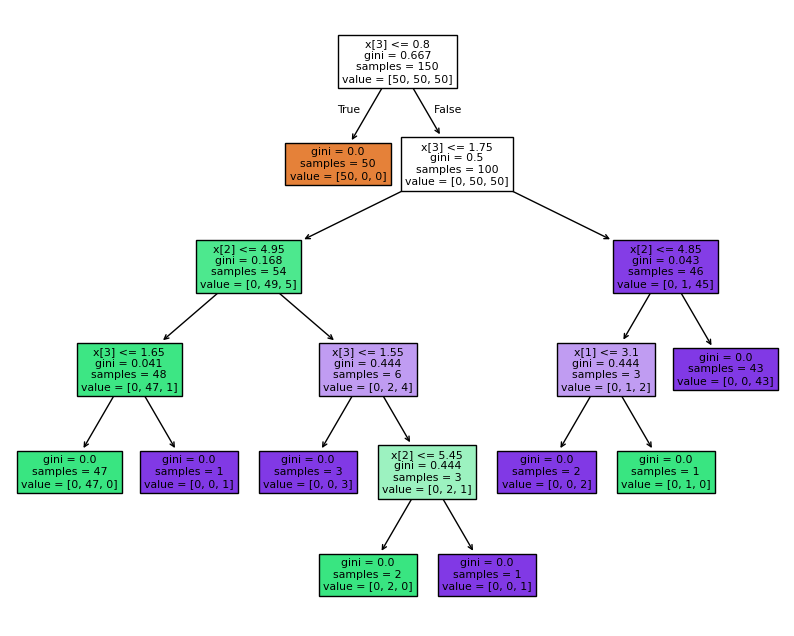

In [144]:
# sklearn
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)
fig = plt.figure(figsize=(10, 8))
tree.plot_tree(clf, filled=True)
plt.show()

In [110]:
# our implementation
cart = CART(max_depth=5, min_samples_split=2)
cart.fit(iris_data)
tree_graph = visualize_tree(cart)
tree_graph.render('decision_tree', view=True)

'decision_tree.png'

### Using heart.csv

In [46]:
def train_test_split(data, test_size=0.4, val_size=0.2, random_state=2060):
    """
    Split the data into training and testing sets randomly.

    Parameters:
    - data: 2D numpy array, the entire dataset.
    - test_size: float, the proportion of the data to include in the test split.
    - random_state: int, the seed used by the random number generator.

    Returns:
    - train_data: 2D numpy array, the training set.
    - test_data: 2D numpy array, the testing set.
    """
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = data.shape[0]
    indices = np.random.permutation(n_samples) # shuffling
    test_size_absolute = int(n_samples * test_size)
    test_indices = indices[:test_size_absolute]
    remaining_indices = indices[test_size_absolute:]
    val_size_absolute = int(len(remaining_indices) * val_size)
    val_indices = remaining_indices[:val_size_absolute]
    train_indices = remaining_indices[val_size_absolute:]
    
    train_data = data[train_indices]
    val_data = data[val_indices]
    test_data = data[test_indices]
    return train_data, val_data, test_data

In [59]:
def kfold_cv_CART(data, depths, alphas, k=5):
    """
    针对CART模型实现K-fold交叉验证，并返回最优参数组合。
    
    参数:
    - CART_class: CART模型类。
    - param_grid: 一个字典，包含模型超参数及其候选值。
      例如：{'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]}。
    - X: 特征数据，二维数组。
    - y: 标签数据，一维数组。
    - k: K-fold交叉验证的折数，默认为5。
    
    返回:
    - 最佳参数组合 (dict)。
    - 对应的最高准确率 (float)。
    """
    best_score = -np.inf
    best_params = None
    fold_size = len(data) // k
    
    for depth in depths:
        for alpha in alphas:
            fold_scores = []
            model = CART(max_depth=depth, alpha=alpha )
            # 遍历每一折
            for i in range(k):
                val_start = i * fold_size
                val_end = (i + 1) * fold_size
                # 验证集
                val_data = data[val_start:val_end]
                # 训练集
                train_data = np.concatenate([data[:val_start], data[val_end:]])
                # 创建并训练CART模型
                model.fit(train_data)
                model.prune(val_data)
                # 计算验证集准确率
                val_accuracy = model.accuracy(val_data)
                fold_scores.append(val_accuracy)

            # 计算当前参数组合的平均得分
            mean_score = np.mean(fold_scores)
            print(f"Score: {mean_score:.3f}")

            # 如果当前参数组合的得分更好，则更新最佳参数和得分
            if mean_score > best_score:
                best_score = mean_score
                best_params = ['depth', depth, 'alpha', alpha]

    return best_params, best_score

In [49]:
data = np.loadtxt("heartdvd.csv", delimiter=",", skiprows=1)
train_data, val_data, test_data = train_test_split(data, test_size=0.4, random_state=2060)
model = CART(max_depth=10, min_samples_split=10)
model.fit(train_data)
model.prune(val_data)
train_accuracy = model.accuracy(train_data)
test_accuracy = model.accuracy(test_data)
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")
tree_graph = visualize_tree(model)
tree_graph.render('decision_tree', view=True)

Training accuracy: 0.829
Testing accuracy: 0.766


'decision_tree.png'

In [60]:
data1, _, _ = train_test_split(data, test_size=0, val_size=0, random_state=2060)
depths = np.linspace(5, 15, 11)
alphas = np.linspace(0.001, 0.05, 5)

kfold_cv_CART(data1, depths, alphas, k=5)

Score: 0.862
Score: 0.842
Score: 0.796
Score: 0.777
Score: 0.751
Score: 0.899
Score: 0.873
Score: 0.820
Score: 0.783
Score: 0.737
Score: 0.902
Score: 0.871
Score: 0.822
Score: 0.785
Score: 0.739
Score: 0.915
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729
Score: 0.916
Score: 0.882
Score: 0.818
Score: 0.776
Score: 0.729


(['depth', np.float64(9.0), 'alpha', np.float64(0.001)],
 np.float64(0.9160975609756097))

In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=2060, ccp_alpha=0.001)
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
model.fit(X_train, y_train)

# Predict on the training and testing datasets
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Compute the accuracies
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Print the results
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Testing accuracy: {test_accuracy:.3f}")

Training accuracy: 0.974
Testing accuracy: 0.912


[Text(0.5368150684931506, 0.9444444444444444, 'x[2] <= 0.5\ngini = 0.5\nsamples = 575\nvalue = [287, 288]'),
 Text(0.2808219178082192, 0.8333333333333334, 'x[12] <= 2.5\ngini = 0.345\nsamples = 284\nvalue = [221, 63]'),
 Text(0.4088184931506849, 0.8888888888888888, 'True  '),
 Text(0.1780821917808219, 0.7222222222222222, 'x[11] <= 0.5\ngini = 0.49\nsamples = 128\nvalue = [73, 55]'),
 Text(0.1095890410958904, 0.6111111111111112, 'x[10] <= 1.5\ngini = 0.408\nsamples = 70\nvalue = [20, 50]'),
 Text(0.0547945205479452, 0.5, 'x[6] <= 0.5\ngini = 0.499\nsamples = 38\nvalue = [18, 20]'),
 Text(0.0273972602739726, 0.3888888888888889, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(0.0821917808219178, 0.3888888888888889, 'x[3] <= 117.5\ngini = 0.375\nsamples = 24\nvalue = [18, 6]'),
 Text(0.0547945205479452, 0.2777777777777778, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.1095890410958904, 0.2777777777777778, 'x[8] <= 0.5\ngini = 0.18\nsamples = 20\nvalue = [18, 2]'),
 Text(0.0821917

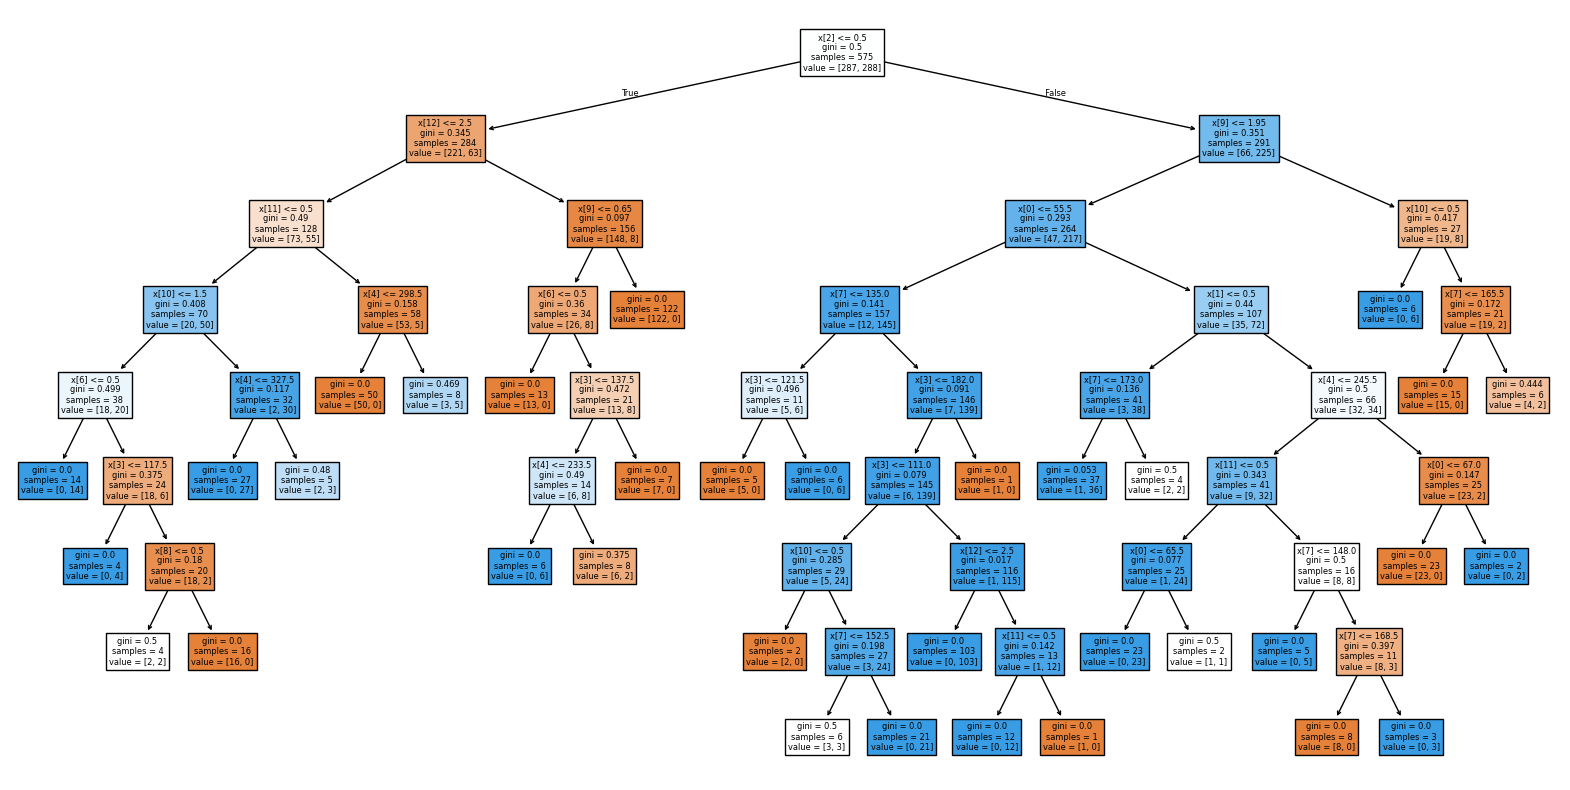

In [16]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True)